In [5]:
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import poisson, nbinom, binom
import plotting_style

In [6]:
class PoissonOffspring:
    def __init__(self, mu):
        self.mu = mu
        self.rv = poisson(mu=self.mu)
        
    def sample(self, size):
        return self.rv.rvs(size=size)
        
class NBinomOffspring:
    def __init__(self, mu, alpha):
        self.mu, self.alpha = mu, alpha
        
        # Convert (mu, alpha) -> (n, p)
        var = mu + alpha * mu ** 2
        n, p = mu ** 2 / (var - mu), mu / var
        self.rv = nbinom(n,p)
        
    def sample(self, size):
        return self.rv.rvs(size=size)
    
    
class BinomialOffspring:
    def __init__(self, n,p):
        self.n = n
        self.p = p
        self.rv = binom(n, p)
        
    def sample(self, size):
        return self.rv.rvs(size=size)

In [7]:
p_dist = PoissonOffspring(1.5)
nb_dist = NBinomOffspring(1.5, 0.1)
p_dist.rv.mean(), nb_dist.rv.mean()

(1.5, 1.4999999999999998)

In [8]:
p_dist.rv.var(), nb_dist.rv.var()

(1.5, 1.7249999999999996)

In [11]:
class GaltonWatson:
    def __init__(self, dist):
        self.dist = dist
        
    def sample(self, i0, max_gen):
        # Assume everything zero after initial time step
        pop = np.zeros(max_gen+1).astype(int)
        pop[0] = i0
        
        # Simulate transmission while population exists
        gen = 0
        while gen < max_gen and pop[gen] > 0:
            gen += 1 
            pop[gen] = self.dist.sample(size=pop[gen-1]).sum()
            
        # Could also save extinction event or time to extinction
        is_extinct = (gen != max_gen)
        time_to_extinct = gen if is_extinct else -1
        return pop #, is_extinct, time_to_extinct
    
    def sample_n(self, i0, max_gen, n_sims):
        return np.stack(
        [self.sample(i0, max_gen) for _ in range(n_sims)]
    )
    

In [12]:
GaltonWatson(p_dist).sample(1, 10)

array([  1,   2,   6,   7,  12,  16,  27,  37,  48,  79, 122])

In [13]:
GaltonWatson(nb_dist).sample(1, 10)

array([ 1,  4,  4,  7,  8, 11, 14, 24, 43, 70, 87])

In [14]:
def fraction_extinct(samples):
    # Check what fraction of last time point are extinct
    return (samples[:,-1] < 1).mean()

In [15]:
# Simulation parameters
i0 = 1
max_gen = 10
n_sims = 1000
R0 = 1.5
alpha = 0.5

p_dist = PoissonOffspring(R0)
nb_dist = NBinomOffspring(R0, alpha)

[Text(0, 0, 'Poisson'), Text(1, 0, 'NegBinom')]

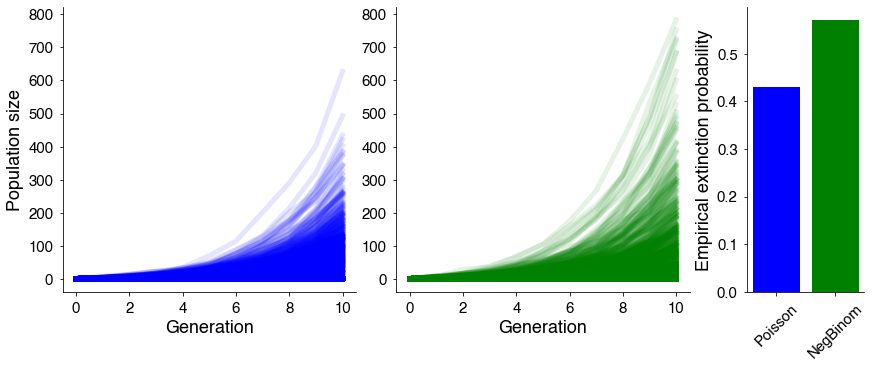

In [111]:
fig = plt.figure(figsize=(12., 5.), constrained_layout=True)
spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios = [1.0, 1.0, 0.4])

# Plot Poisson Offpsring
gw_pois = GaltonWatson(p_dist)
samples_pois = gw_pois.sample_n(i0=i0, max_gen=max_gen, n_sims=n_sims)
ax_pois = fig.add_subplot(spec[0, 0])
ax_pois.plot(samples_pois.T + 1, color="blue", alpha=0.1)
#ax_pois.set_yscale("log")
ax_pois.set_ylabel("Population size")
ax_pois.set_xlabel("Generation")

# Plot Negative Binomial Simulations
gw_nb = GaltonWatson(nb_dist)
samples_nb = gw_nb.sample_n(i0=i0, max_gen=max_gen, n_sims=n_sims)
ax_nb = fig.add_subplot(spec[0, 1], sharey=ax_pois)
ax_nb.plot(samples_nb.T + 1, color="green", alpha=0.1)
#ax_nb.set_yscale("log")
ax_pois.set_xlabel("Generation")
ax_nb.set_xlabel("Generation")

# Plot Fraction extinct
ax_frac_extinct = fig.add_subplot(spec[0, 2])
extinct_prob = np.array([fraction_extinct(samples_pois), fraction_extinct(samples_nb)])
ax_frac_extinct.bar([0,1], extinct_prob, color=["blue", "green"])
ax_frac_extinct.set_ylabel("Empirical extinction probability")
ax_frac_extinct.set_xticks([0,1])
ax_frac_extinct.set_xticklabels(["Poisson", "NegBinom"], rotation=45)

fig.savefig("../figures/branching_process_pois_v_negbinom.png")

In [17]:
# Next repeat and show (empirical) probabilty of extinction as a function of the over-dispersion parameter alpha 
# For a given R0

alpha_vals = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7]

def simulate_prob_extinction(R0, alpha_vals, n_sims, max_gen, i0):
    gw_processes = [GaltonWatson(NBinomOffspring(R0, alpha)) for alpha in alpha_vals]
    sims = [gw.sample_n(i0=i0, max_gen=max_gen, n_sims=n_sims) for gw in gw_processes]
    extinction_probs = [fraction_extinct(sim) for sim in sims]
    return sims, extinction_probs

sims, extinction_probs = simulate_prob_extinction(R0, alpha_vals, n_sims, max_gen, i0)

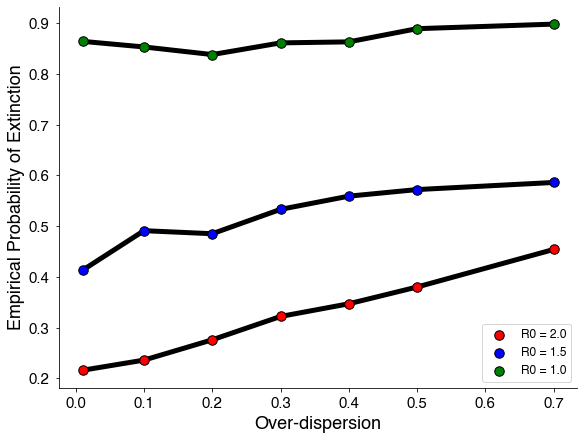

In [114]:
fig = plt.figure(figsize=(8., 6.), constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=1)

# Plot extinction curve R0 = 1.5
ax0 = fig.add_subplot(spec[0, 0])

sims, extinction_probs = simulate_prob_extinction(2.0, alpha_vals, n_sims, max_gen, i0)
ax0.plot(alpha_vals, extinction_probs, color="k")
ax0.scatter(alpha_vals, extinction_probs, color="red", ec="k", label = "R0 = 2.0", s = 90, zorder=3)

sims, extinction_probs = simulate_prob_extinction(1.5, alpha_vals, n_sims, max_gen, i0)
ax0.plot(alpha_vals, extinction_probs, color="k")
ax0.scatter(alpha_vals, extinction_probs, color="blue", ec="k", label = "R0 = 1.5", s = 90, zorder=3)

sims, extinction_probs = simulate_prob_extinction(1.0, alpha_vals, n_sims, max_gen, i0)
ax0.plot(alpha_vals, extinction_probs, color="k")
ax0.scatter(alpha_vals, extinction_probs, color="green", ec="k", label = "R0 = 1.0",  s = 90, zorder=3)

ax0.legend()
ax0.set_xlabel("Over-dispersion")
ax0.set_ylabel("Empirical Probability of Extinction")

fig.savefig("../figures/prob_extinction_changing_overdispersion.png")

In [ ]:
# Comparing analytic estimates of generation time to empirical
# To do this, you'd use the generating function for the offspring distribution.

# Confidence Interval

In [ ]:
# Let's say we're trying to estimate the probability of an event occuring 
# with a binomial with event probability p and count n

# B ~ Binom(n,p)

# Var[B] = n * p * (1 - p)
# Var[B / n] = 1/n^2 * Var[B] = p * (1 - p) / n
# SE[p]



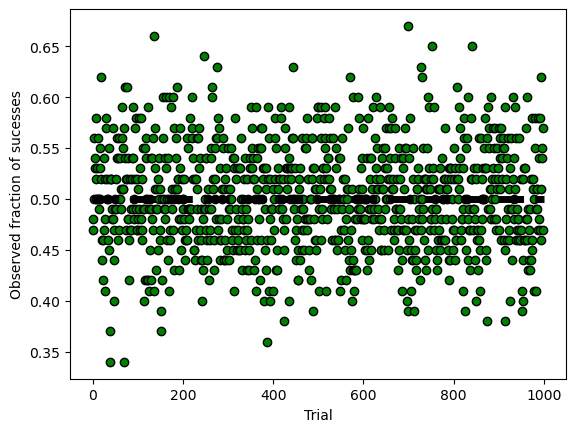

In [48]:
# Talking confidence intervals
true_p = 0.5
n = 100
prob_dist = BinomialOffspring(n, true_p)
successes = prob_dist.sample(1000)

# 95% of the intervals should contain the true value
plt.scatter(np.arange(1000), successes / n, ec="k", color="g")
plt.xlabel("Trial")
plt.ylabel("Observed fraction of sucesses")

plt.hlines(xmin=0, xmax=1000, y=true_p, color="k", linestyle="--", linewidth=5.0)

Text(0.5, 0, 'Observed fraction of sucesses')

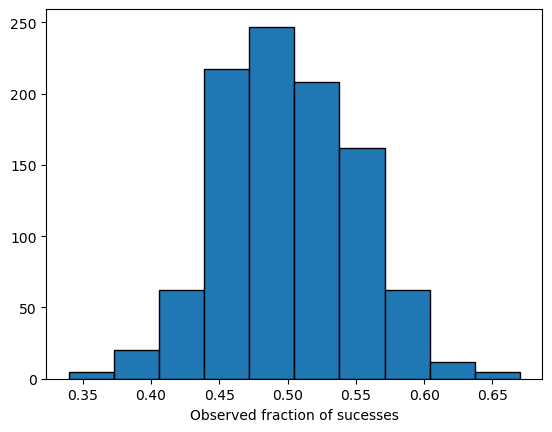

In [49]:
plt.hist(successes / n, ec="k")
plt.xlabel("Observed fraction of sucesses")

In [47]:
def binomial_ci(n, k_obs):
    p_est = k_obs / n # Estimate for prob
    se = np.sqrt(p_est * (1-p_est) / n)
    ci_lower, ci_upper = p_est - 1.96 * se, p_est + 1.96 * se
    return p_est, ci_lower, ci_upper

In [51]:
p_est, ci_lower, ci_upper = binomial_ci(n, successes)

In [57]:
in_ci = (ci_lower < true_p) * (true_p < ci_upper)

In [58]:
in_ci.mean()

0.944

In [58]:
def simulate_prob_extinction_pois(R0_vals, n_sims, max_gen, i0):
    gw_processes = [GaltonWatson(PoissonOffspring(R0)) for R0 in R0_vals]
    sims = [gw.sample_n(i0=i0, max_gen=max_gen, n_sims=n_sims) for gw in gw_processes]
    extinction_probs = [fraction_extinct(sim) for sim in sims]
    return sims, extinction_probs

R0_vals = np.linspace(0.5, 3.0, 26)

sims, extinction_probs = simulate_prob_extinction_pois(R0_vals, n_sims, max_gen, i0)

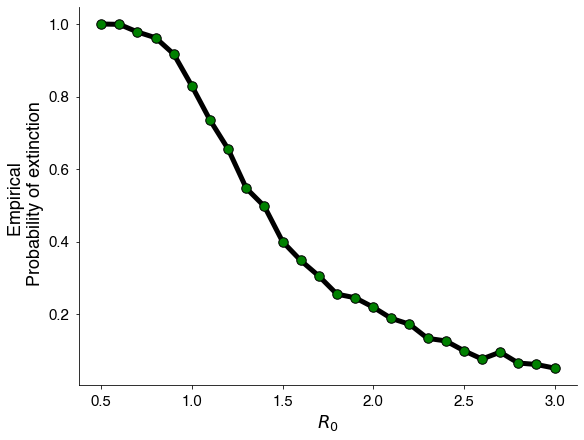

In [108]:
fig = plt.figure(figsize=(8., 6.), constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=1)

# Get SEs
def binomial_se(n, k_obs):
    p_est = k_obs / n # Estimate for prob
    se = np.sqrt(p_est * (1-p_est) / n)
    return se

ses = [1.96 * binomial_se(n_sims, prob * n_sims) for prob in extinction_probs]

# Plot extinction curve for varying R0 for Poisson model
ax0 = fig.add_subplot(spec[0, 0])
ax0.plot(R0_vals, extinction_probs, color="k")
ax0.scatter(R0_vals, extinction_probs, color="green", ec="k",  s = 90, zorder=3)
#ax0.errorbar(R0_vals, extinction_probs, yerr=ses, color="k")
ax0.set_ylabel("Empirical \n Probability of extinction")
ax0.set_xlabel("$R_{0}$")

fig.savefig("../figures/pois_extinction_prob_R0.png")

Text(0.5, 1.0, '$R_{0} = 2.0$')

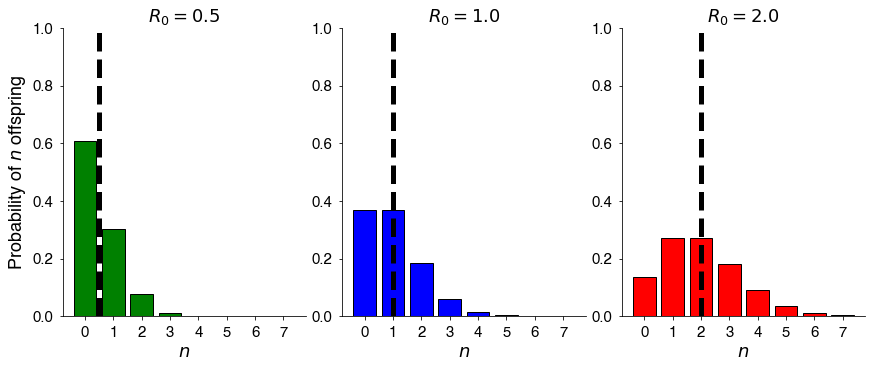

In [102]:
fig = plt.figure(figsize=(12., 5.), constrained_layout=True)
spec = fig.add_gridspec(ncols=3, nrows=1)
ax0 = fig.add_subplot(spec[0])
ax1 = fig.add_subplot(spec[1])
ax2 = fig.add_subplot(spec[2])


def plot_dist(ax, xs, dist, color, label):
    pmf = dist.rv.pmf(xs)
    ax.bar(xs, pmf, color=color, ec="k", label=label)
    ax.set_xticks(xs)

xs = np.arange(8)

# Plot distribution and mean
plot_dist(ax0, xs, PoissonOffspring(0.5), "green", "$R_{0} = 0.5$")
ax0.axvline(x=0.5, color="k", linestyle="--")

plot_dist(ax1, xs, PoissonOffspring(1.0), "blue", "$R_{0} = 1$ ")
ax1.axvline(x=1.0, color="k", linestyle="--")

plot_dist(ax2, xs, PoissonOffspring(2.0), "red", "$R_{0} = 2.0$")
ax2.axvline(x=2.0, color="k", linestyle="--")


# Set limits
ax0.set_ylim(0,1)
ax1.set_ylim(0,1)
ax2.set_ylim(0,1)

# Labels
ax0.set_ylabel("Probability of $n$ offspring")
ax0.set_xlabel("$n$")
ax1.set_xlabel("$n$")
ax2.set_xlabel("$n$")


# Add titles
ax0.set_title("$R_{0} = 0.5$")
ax1.set_title("$R_{0} = 1.0$")
ax2.set_title("$R_{0} = 2.0$")

In [103]:
fig.savefig("../figures/offspring-distributions.png")

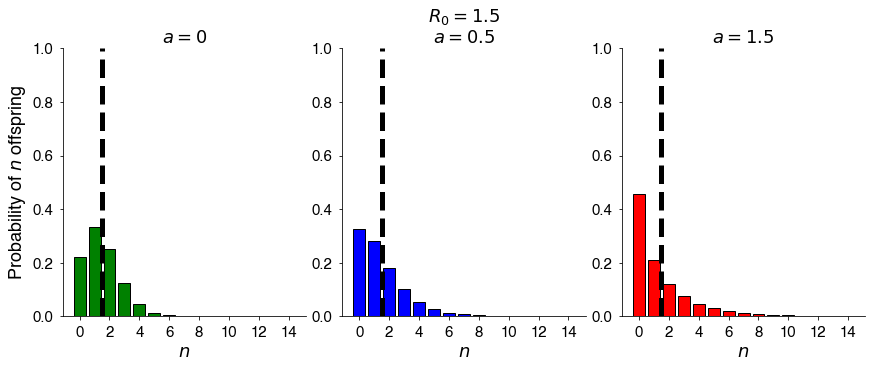

In [162]:
fig = plt.figure(figsize=(12., 5.), constrained_layout=True)
spec = fig.add_gridspec(ncols=3, nrows=1)
ax0 = fig.add_subplot(spec[0])
ax1 = fig.add_subplot(spec[1])
ax2 = fig.add_subplot(spec[2])


def plot_dist(ax, xs, dist, color, label):
    pmf = dist.rv.pmf(xs)
    ax.bar(xs, pmf, color=color, ec="k", label=label)
    ax.set_xticks(xs[::2])

xs = np.arange(15)

# Plot distribution and mean
R0_mean = 1.5
plot_dist(ax0, xs, PoissonOffspring(R0_mean), "green", "$R_{0}=1.5$")
ax0.axvline(x=R0_mean, color="k", linestyle="--")

plot_dist(ax1, xs, NBinomOffspring(R0_mean, 0.5), "blue", "$\alpha = 0.5$")
ax1.axvline(x=R0_mean, color="k", linestyle="--")

plot_dist(ax2, xs, NBinomOffspring(R0_mean, 1.5), "red", "$\alpha = 1.5$")
ax2.axvline(x=R0_mean, color="k", linestyle="--")


# Set limits
ax0.set_ylim(0,1)
ax1.set_ylim(0,1)
ax2.set_ylim(0,1)

# Labels
ax0.set_ylabel("Probability of $n$ offspring")
ax0.set_xlabel("$n$")
ax1.set_xlabel("$n$")
ax2.set_xlabel("$n$")


# Add titles
ax0.set_title("\n$a = 0$")
ax1.set_title("$R_{0}=1.5$\n$a=0.5$")
ax2.set_title("\n$a=1.5$")

fig.savefig("../figures/offspring-distributions-nb.png")